# MOIRAI

[MOIRAI](https://arxiv.org/pdf/2402.02592) aims to be a unified training for U Time series forecasting.

In [2]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
from gluonts.dataset.repository import dataset_recipes


from gluonts.dataset.split import split
import numpy as np
import torch
from einops import rearrange
from uni2ts.eval_util.data import get_gluonts_test_dataset
from uni2ts.eval_util.plot import plot_single, plot_next_multi
from uni2ts.model.moirai import MoiraiForecast, MoiraiModule

from gluonts.dataset.pandas import PandasDataset
import pandas as pd

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Settings
SIZE: model size, select the model size of Moirai to perform inference with

CTX: context length, how many time steps the model will take as input for inference

PSZ: patch size, how many time steps to perform patching with

BSZ: batch size, number of samples in each batch for inference

In [3]:
SIZE = "small"  # model size: choose from {'small', 'base', 'large'}
CTX = 368  # context length: any positive integer
PRED = 60  # prediction length: any positive integer
PSZ = "auto"  # patch size: choose from {"auto", 8, 16, 32, 64, 128}
BSZ = 32  # batch size: any positive integer

## 1. Earthquake Catalogs



In [4]:
# first we load data/data_qtm_catalog.csv
df = pd.read_csv("../data/data_qtm_catalog.csv")
df.head()

,datetime,count
0,2008-01-01,120
1,2008-01-02,89
2,2008-01-03,146
3,2008-01-04,166
4,2008-01-05,94


In [5]:
# calculate the time difference between each datetime to set up the dt
# convert the datetime column to datetime object
df["datetime"] = pd.to_datetime(df["datetime"])
dt = df["datetime"].diff().dt.total_seconds().fillna(0).mean()
# convert seconds to days
dt = np.ceil(dt / (60 * 60 * 24))
print(dt)

1.0


In [9]:
n_timeseries = 5

In [10]:
# select a random start date from the data frame to generate a 2-year time series from the catalog. Make 20 examples of 2-year time series.
# we will make a list of 20 dictionaries, each dictionary will have a start date and a time series
# initialize a list of 20 dictionaries
df_list = [pd.DataFrame() for _ in range(n_timeseries)]
for ik in range(n_timeseries):
    start_date = df["datetime"].sample().values[0]
    start_date = pd.to_datetime(start_date)
    print(start_date)
    # create a time series for the next 2 years
    end_date = start_date + pd.DateOffset(years=2)
    # create a time series from the catalog
    time_series = df[(df["datetime"] >= start_date) & (df["datetime"] <= end_date)]
    time_series = time_series.set_index("datetime")
    time_series = time_series.resample(f"{dt}D").mean().interpolate()
    time_series = time_series.fillna(method="ffill")
    time_series = time_series.fillna(method="bfill")
    time_series = time_series.reset_index()
    df_list[ik] = time_series
# take each "count" column from the 20 dataframes and assemble a single wide dataframe ith all the columns
# initialize a list of 20 dataframes
df_list_count = [pd.DataFrame() for _ in range(n_timeseries)]
for ik in range(n_timeseries):
    df_list_count[ik] = df_list[ik]["count"]
    df_list_count[ik] = df_list_count[ik].rename(f"{ik}")
df_wide = pd.concat(df_list_count, axis=1)
# add a first column with a date that is the same for all the 20 time series
df_wide["datetime"] = np.arange(0, len(df_wide)) * pd.Timedelta(days=dt)
# convert datetime to integer
df_wide["datetime"] = df_wide["datetime"].dt.days
# move the last column to the first position
cols = df_wide.columns.tolist()
cols = cols[-1:] + cols[:-1]
df_wide = df_wide[cols]
df_wide.head()


2015-07-23 00:00:00
2010-10-05 00:00:00
2008-12-19 00:00:00
2015-10-08 00:00:00
2017-07-06 00:00:00


/var/folders/j4/3rbzxjb16kv66g_p4wkzq16h0000gn/T/ipykernel_41720/1362343524.py:15: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  time_series = time_series.fillna(method="ffill")
/var/folders/j4/3rbzxjb16kv66g_p4wkzq16h0000gn/T/ipykernel_41720/1362343524.py:16: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  time_series = time_series.fillna(method="bfill")
/var/folders/j4/3rbzxjb16kv66g_p4wkzq16h0000gn/T/ipykernel_41720/1362343524.py:15: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  time_series = time_series.fillna(method="ffill")
/var/folders/j4/3rbzxjb16kv66g_p4wkzq16h0000gn/T/ipykernel_41720/1362343524.py:16: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffi

,datetime,0,1,2,3,4
0,0,217.0,225.0,163.0,187.0,218.0
1,1,270.0,260.0,162.0,241.0,219.0
2,2,197.0,310.0,170.0,142.0,252.0
3,3,200.0,285.0,125.0,180.0,236.0
4,4,203.0,284.0,162.0,208.0,236.0


In [8]:
# convert time series to torch array
data = torch.tensor(df["count"].values).float()

In [12]:
# create a sample for the daily data, using 1 year data as context window and predicting the next 2 months.
inp = {
    "target": data[0, start_date:last_date],  
    "start": start_date,
}
label = {
    "target": data[0,last_date:last_date+prediction_length], 
    "start": last_date,
}

In [58]:
# Prepare model
model = MoiraiForecast(
    module=MoiraiModule.from_pretrained(f"Salesforce/moirai-1.0-R-small"),
    prediction_length=prediction_length,
    context_length=CTX,
    patch_size="auto",
    num_samples=100,
    target_dim=1,
    feat_dynamic_real_dim=0,
    past_feat_dynamic_real_dim=0,
)

# Time series values. Shape: (batch, time, variate)
past_target = rearrange(
    torch.as_tensor(inp["target"], dtype=torch.float32), "t -> 1 t 1" # 1 batch, t time, 1 variate
)
# 1s if the value is observed, 0s otherwise. Shape: (batch, time, variate)
past_observed_target = torch.ones_like(past_target, dtype=torch.bool)
# 1s if the value is padding, 0s otherwise. Shape: (batch, time)
past_is_pad = torch.zeros_like(past_target, dtype=torch.bool).squeeze(-1)


In [48]:
d ysadw6ant("Shape of past_observed_target:", past_observed_target.shape)
print("Shape of past_is_pad:", past_is_pad.shape)

Shape of past_target: torch.Size([1, 700, 1])
Shape of past_observed_target: torch.Size([1, 700, 1])
Shape of past_is_pad: torch.Size([1, 700])


In [59]:
forecast = model(
    past_target=past_target,
    past_observed_target=past_observed_target,
    past_is_pad=past_is_pad)

RuntimeError: The size of tensor a (88) must match the size of tensor b (95) at non-singleton dimension 1

In [50]:
PRED

60

In [51]:
print(
    "median prediction:\n",
    np.round(np.median(forecast[0], axis=0), decimals=1),
)
print("ground truth:\n", label["target"])

median prediction:
 [ -978998.9  -581344.4  -820777.1 -1176112.   -990797.2  -956250.1
  -963290.9 -1174191.5 -1161021.  -1222086.2  -881256.8 -1122600.8
  -468102.8 -1086643.  -1038053.1 -1600476.4 -1118548.8 -1053508.
 -1776452.4 -1181949.  -1501653.5 -1382674.6 -1235815.   -998767.6
 -1343710.8 -1374215.   -817125.8 -1033905.8 -1593953.8 -1087976.5
 -1577775.2 -1390487.5 -1063673.  -1199524.  -1541937.4 -1127619.1
 -1318406.8 -1078823.2 -1403501.  -1366358.9  -876096.  -1447719.2
  -779486.9 -1539784.8 -1195491.2 -1205486.2 -1617281.9 -1556280.9
 -1055165.2 -1243955.5]
ground truth:
 tensor([   26936.2559,  -453052.6250,  -835105.9375, -1088777.5000,
        -1411582.3750, -1663795.6250, -1693551.2500, -1494270.2500,
        -1196284.0000,  -963077.2500,  -540632.1250,   148243.9375,
          516344.4062,   754356.5625,  1226814.7500,  1555539.6250,
         1556498.0000,  1647952.5000,  1604301.3750,  1361001.5000,
         1191737.7500,  1187537.6250,  1099060.5000,   982942.2500

In [52]:
forecast[0][0].shape

torch.Size([50])

In [56]:
CTX

368

In [46]:
last_date, last_date+prediction_length, prediction_length,PRED

(800, 850, 50, 60)

50
50


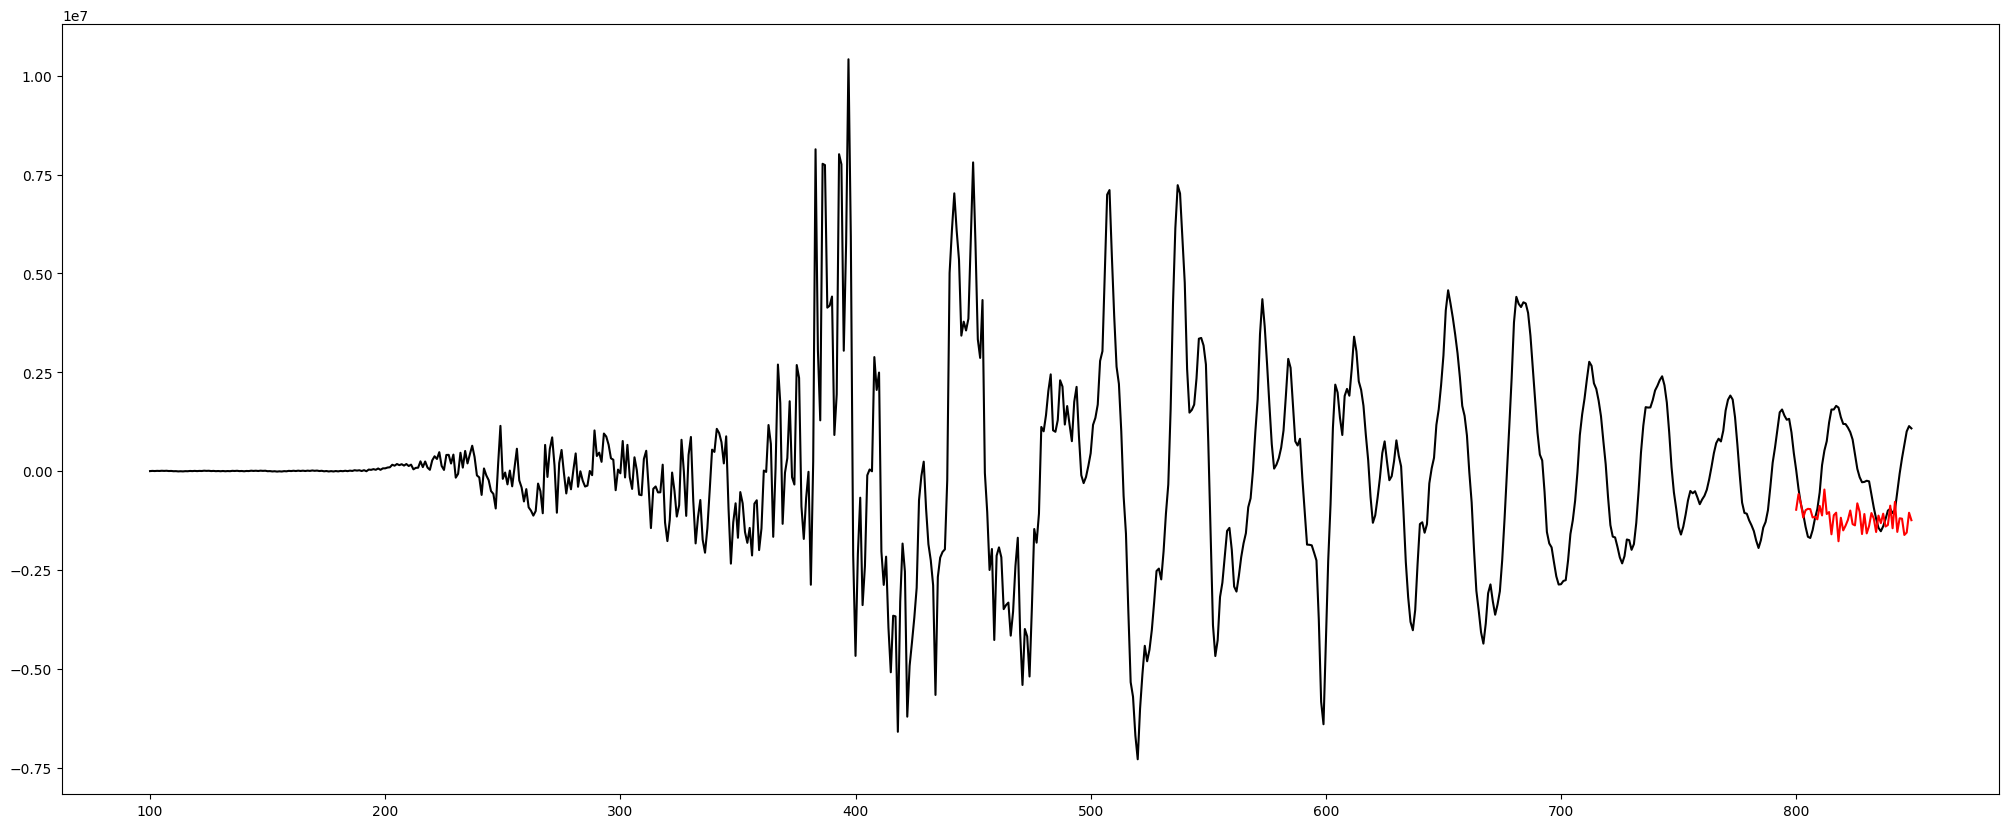

In [55]:
# now plot the input data, the ground thruth and the predictions
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(25, 10))
t1 = np.arange(start_date, last_date+prediction_length)
t2 = np.arange(last_date, last_date + prediction_length)
print(len(np.median(forecast[0], axis=0)))
print(len(t2))
plt.plot(t1,data[0,start_date:last_date+prediction_length].T,'k')
plt.plot(t2,np.median(forecast[0], axis=0),'r')


## Rolling evaluation

In [ ]:
TEST = 100
PDT = PRED

In [ ]:
# Split into train/test set
train, test_template = split(
    dataset, offset=-TEST
)  # assign last TEST time steps as test set

# Construct rolling window evaluation
test_data = test_template.generate_instances(
    prediction_length=PDT,  # number of time steps for each prediction
    windows=TEST // PDT,  # number of windows in rolling window evaluation
    distance=PDT,  # number of time steps between each window - distance=PDT for non-overlapping windows
)



### Make predictions

In [ ]:
# Prepare model
model = MoiraiForecast(
    module=MoiraiModule.from_pretrained(f"Salesforce/moirai-1.0-R-small"),
    prediction_length=PDT,
    context_length=CTX,
    patch_size=PSZ,
    num_samples=100,
    target_dim=1,
    feat_dynamic_real_dim=dataset.num_feat_dynamic_real,
    past_feat_dynamic_real_dim=dataset.num_past_feat_dynamic_real,
)

predictor = model.create_predictor(batch_size=BSZ)
forecasts = predictor.predict(test_data.input)

input_it = iter(test_data.input)
label_it = iter(test_data.label)
forecast_it = iter(forecasts)

(0.0, 20.0)

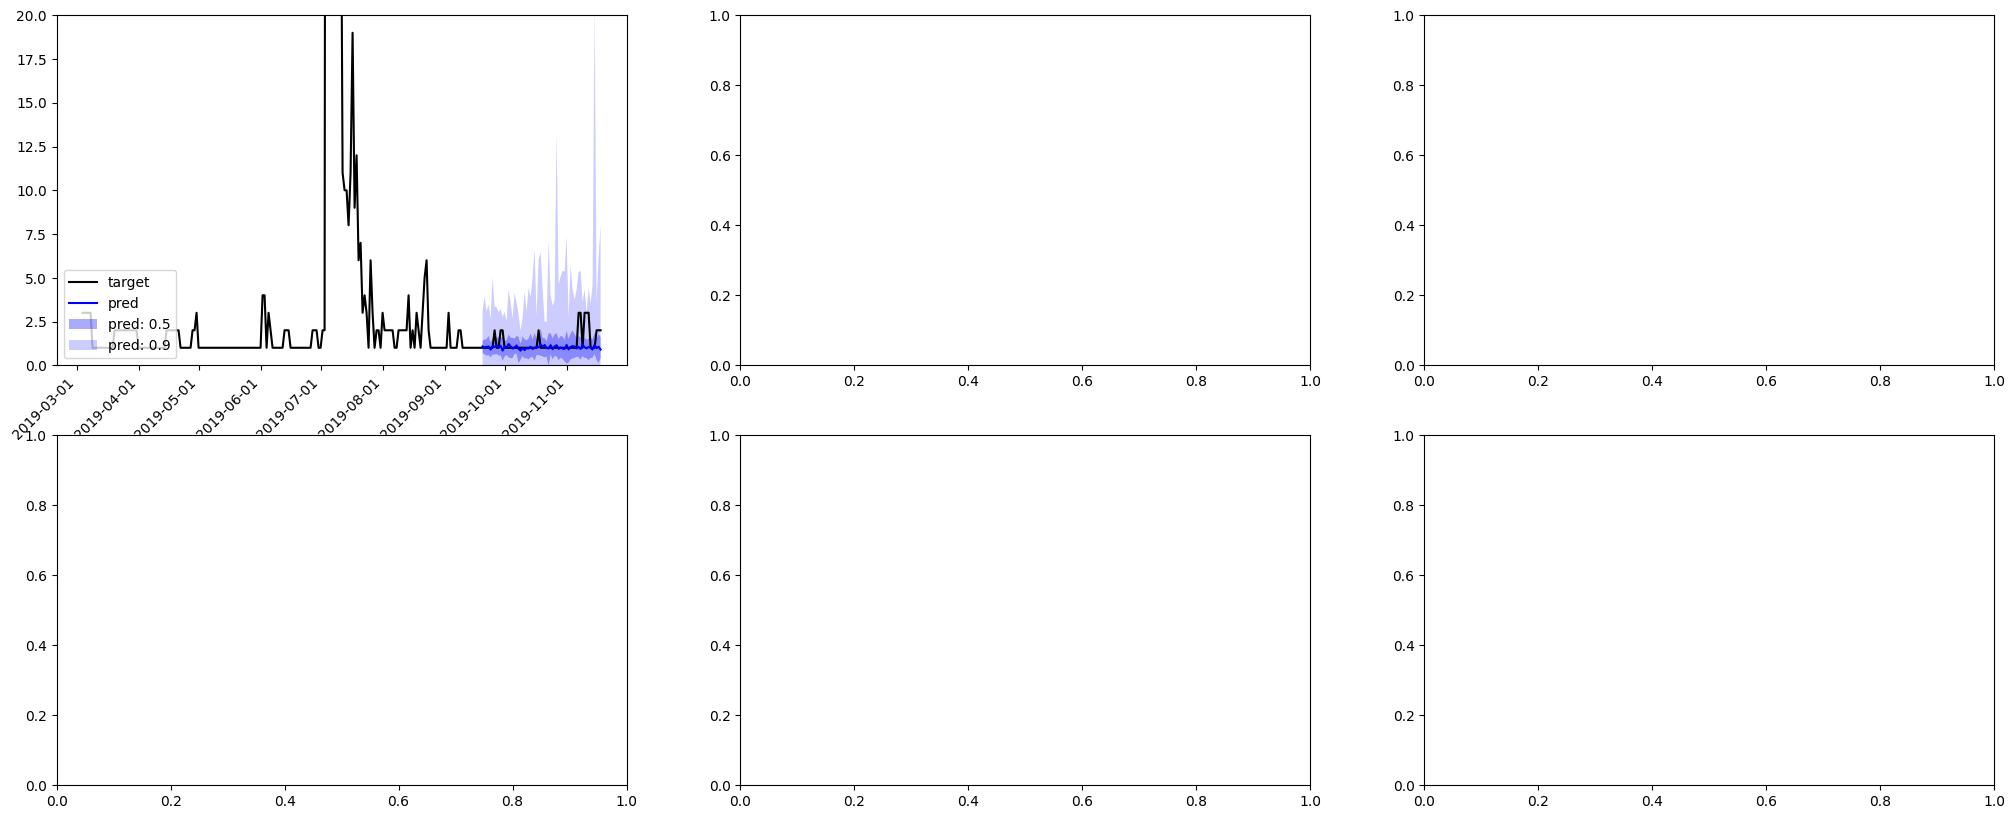

In [ ]:
# Make predictions
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(25, 10))
plot_next_multi(
    axes,
    input_it,
    label_it,
    forecast_it,
    context_length=200,
    intervals=(0.5, 0.9),
    dim=None,
    name="pred",
    show_label=True,
)
axes[0,0].set_ylim([0,20])